In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# 读取数据
data = pd.read_csv("../datasets/train.csv")

# 从 data 中随机抽样 10000 条
sampled_data = data.sample(n=10000, random_state=42)  # 设置 random_state 保证可复现

# 特征和目标
feature_cols = [
    'LAE71AA101ZZ.AV', 'A1SPRFLOW.AV', 'LAE72AA101ZZ.AV', 'B1SPRFLOW.AV',
    'LAE73AA101ZZ.AV', 'A2SPRFLOW.AV', 'LAE74AA101ZZ.AV', 'B2SPRFLOW.AV',
    'PSHAOUTTE.AV', 'PSHBOUTTE.AV'
]

# target_cols = ['SHAOUTTE.AV']
target_cols = ['SHBOUTTE.AV']

# 数据归一化
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(sampled_data[feature_cols])
y = scaler_y.fit_transform(sampled_data[target_cols])

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 搜索最佳 n_estimators（树的数量）
param_grid_n_estimators = {
    'n_estimators': [10,20,30,40,50]
}

grid_search_n = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_n_estimators,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search_n.fit(X_train, y_train)
print("Best n_estimators:", grid_search_n.best_params_)


In [ ]:
# 基于最佳 n_estimators 继续调 max_depth
param_grid_depth = {
    'max_depth': [5, 10, 15, 20]
}

grid_search_depth = GridSearchCV(
    RandomForestRegressor(n_estimators=grid_search_n.best_params_['n_estimators'], random_state=42),
    param_grid_depth,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search_depth.fit(X_train, y_train)
print("Best max_depth:", grid_search_depth.best_params_)


In [ ]:
param_grid_split = {
    'min_samples_split': [2, 5, 10]
}

grid_search_split = GridSearchCV(
    RandomForestRegressor(
        n_estimators=grid_search_n.best_params_['n_estimators'],
        max_depth=grid_search_depth.best_params_['max_depth'],
        random_state=42
    ),
    param_grid_split,
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search_split.fit(X_train, y_train)
print("Best min_samples_split:", grid_search_split.best_params_)


In [ ]:
param_grid_leaf = {
    'min_samples_leaf': [1, 2, 4]
}

grid_search_leaf = GridSearchCV(
    RandomForestRegressor(
        n_estimators=grid_search_n.best_params_['n_estimators'],
        max_depth=grid_search_depth.best_params_['max_depth'],
        min_samples_split=grid_search_split.best_params_['min_samples_split'],
        random_state=42
    ),
    param_grid_leaf,
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
grid_search_leaf.fit(X_train, y_train)
print("Best min_samples_leaf:", grid_search_leaf.best_params_)


In [22]:
# 用最佳参数训练最终模型
best_model = RandomForestRegressor(random_state=42,n_estimators=6,max_depth=20,min_samples_split=2,min_samples_leaf=1)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


c:\Users\siming\miniconda3\envs\YOLO\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# 还原预测结果
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# 评估
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")

In [ ]:
# 最佳参数组合
best_params = {
    'n_estimators': grid_search_n.best_params_['n_estimators'],
    'max_depth': grid_search_depth.best_params_['max_depth'],
    'min_samples_split': grid_search_split.best_params_['min_samples_split'],
    'min_samples_leaf': grid_search_leaf.best_params_['min_samples_leaf'],
}

print("Best combined parameters:", best_params)

# 用最佳参数训练最终模型
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# 还原预测结果
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# 评估
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")


In [23]:
import joblib

# 保存训练好的模型
joblib.dump(best_model, 'A_random_forest_model.pkl')

# 同时保存特征和目标的 Scaler
joblib.dump(scaler_X, 'A_RFscaler_X.pkl')
joblib.dump(scaler_y, 'A_RFscaler_y.pkl')


['A_RFscaler_y.pkl']

In [30]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 加载模型和 Scaler
best_model = joblib.load("B_random_forest_model.pkl")
scaler_X = joblib.load("B_RFscaler_X.pkl")
scaler_y = joblib.load("B_RFscaler_y.pkl")


# 特征列
feature_cols = [
    'LAE71AA101ZZ.AV', 'A1SPRFLOW.AV', 'LAE72AA101ZZ.AV', 'B1SPRFLOW.AV',
    'LAE73AA101ZZ.AV', 'A2SPRFLOW.AV', 'LAE74AA101ZZ.AV', 'B2SPRFLOW.AV',
    'PSHAOUTTE.AV','PSHBOUTTE.AV'
]





Test MSE: 93.1871
R2 Score: 0.9976


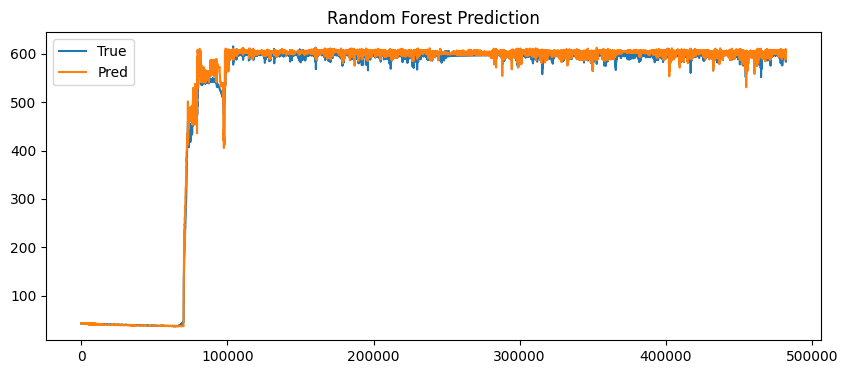

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

testdata = pd.read_csv("../datasets/test.csv")
x_val = scaler_X.fit_transform(testdata[feature_cols])
y_val = scaler_y.fit_transform(testdata[target_cols])

y_pred = best_model.predict(x_val)


# 还原预测结果
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_val.reshape(-1, 1))

# 评估
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")
print(f"R2 Score: {r2_score(y_test_inv, y_pred_inv):.4f}")

plt.figure(figsize=(10,4))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_inv, label='Pred')
plt.title('Random Forest Prediction')
plt.legend()
plt.show()


In [32]:
explainer1 = shap.Explainer(best_model, X_train)
shap_values1 = explainer1(X_train, check_additivity=False)


In [ ]:
shap.initjs()  # 初始化JS
shap.force_plot(explainer1.expected_value, shap_values1, X_train,show=False)

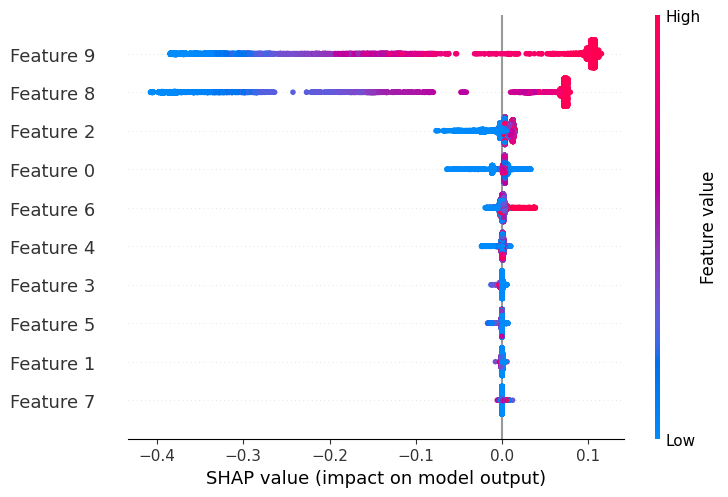

In [33]:
shap.plots.beeswarm(shap_values1)

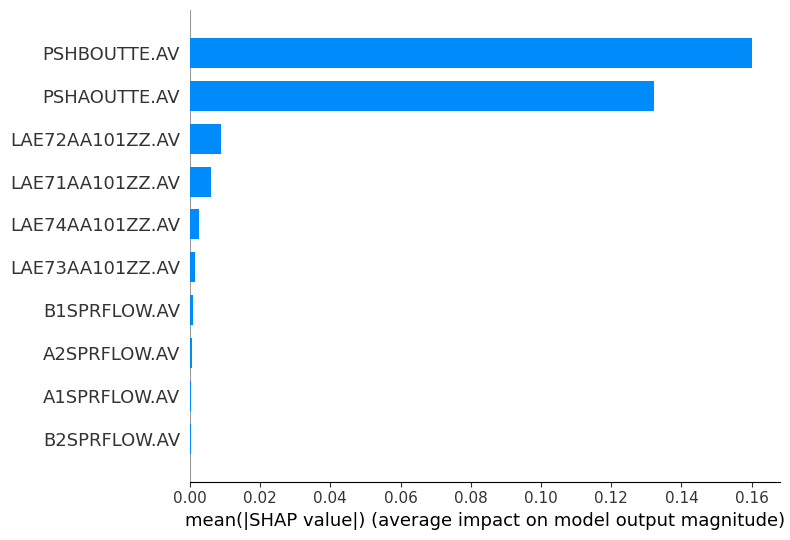

In [34]:
shap.summary_plot(
    shap_values1,         # 第一个目标的 shap 值
    X_train,                  # 原始未缩放的特征值
    feature_names=feature_cols,
    plot_type="bar",
    show=True
)
